# scRNA-seq analysis

In this tutorial, we'll utilize the 10X PBMCs scRNA-seq dataset to showcase the steps for running SIMBA on scRNA-seq datasets.

In [1]:
import os
import simba as si
si.__version__

'1.2'

In [2]:
workdir = 'result_simba_rnaseq'
si.settings.set_workdir(workdir)

Saving results in: result_simba_rnaseq


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# make plots prettier
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

## load example data

In [5]:
adata_CG = si.datasets.rna_10xpmbc3k()

rna_10xpmbc3k.h5ad: 21.5MB [00:07, 2.75MB/s]                                                                           

Downloaded to result_simba_rnaseq/data.


In [6]:
adata_CG

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype'
    var: 'gene_ids'

## preprocessing

In [7]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
2700 cells, 32738 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2700 cells, 13714 genes


In [8]:
si.pp.cal_qc_rna(adata_CG)

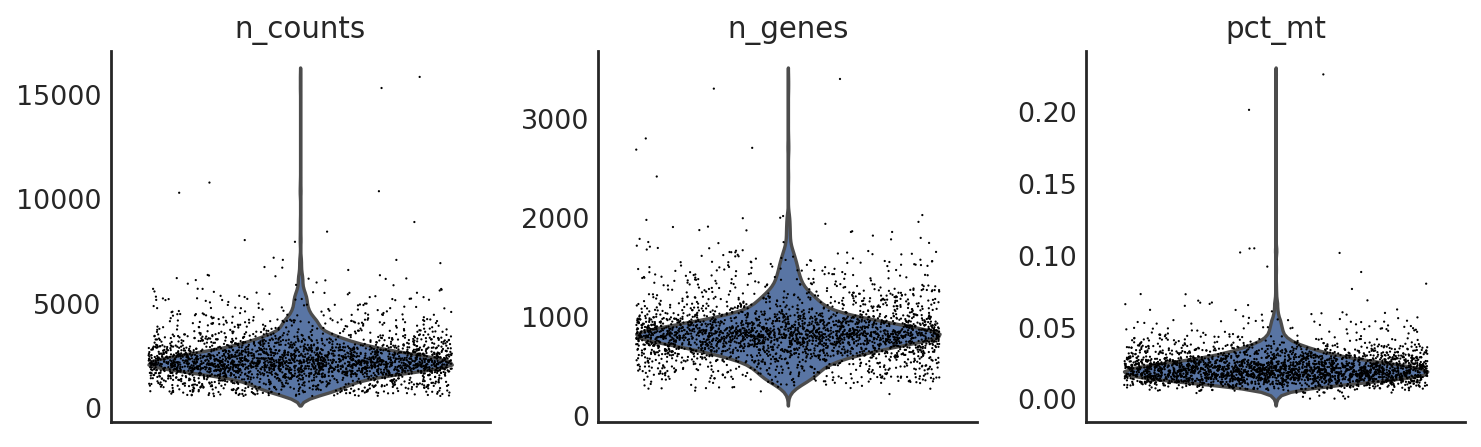

In [9]:
si.pl.violin(adata_CG,list_obs=['n_counts','n_genes','pct_mt'])

Filter out cells if needed:

```python
si.pp.filter_cells_rna(adata,min_n_genes=100)
```

In [10]:
si.pp.normalize(adata_CG,method='lib_size')
si.pp.log_transform(adata_CG)

Optionally, variable gene selection step can be also performed. 

```python
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)
si.pl.variable_genes(adata_CG,show_texts=True)
```

By encoding only variable genes into the graph, the training procedure can be accelerated. However, the embeddings of non-variable genes will not be acquired.

#### discretize RNA expression

This step groups non-zero gene expression values into distinct levels while preserving the original distribution, enabling recognition of different levels of gene expression during the subsequent training.

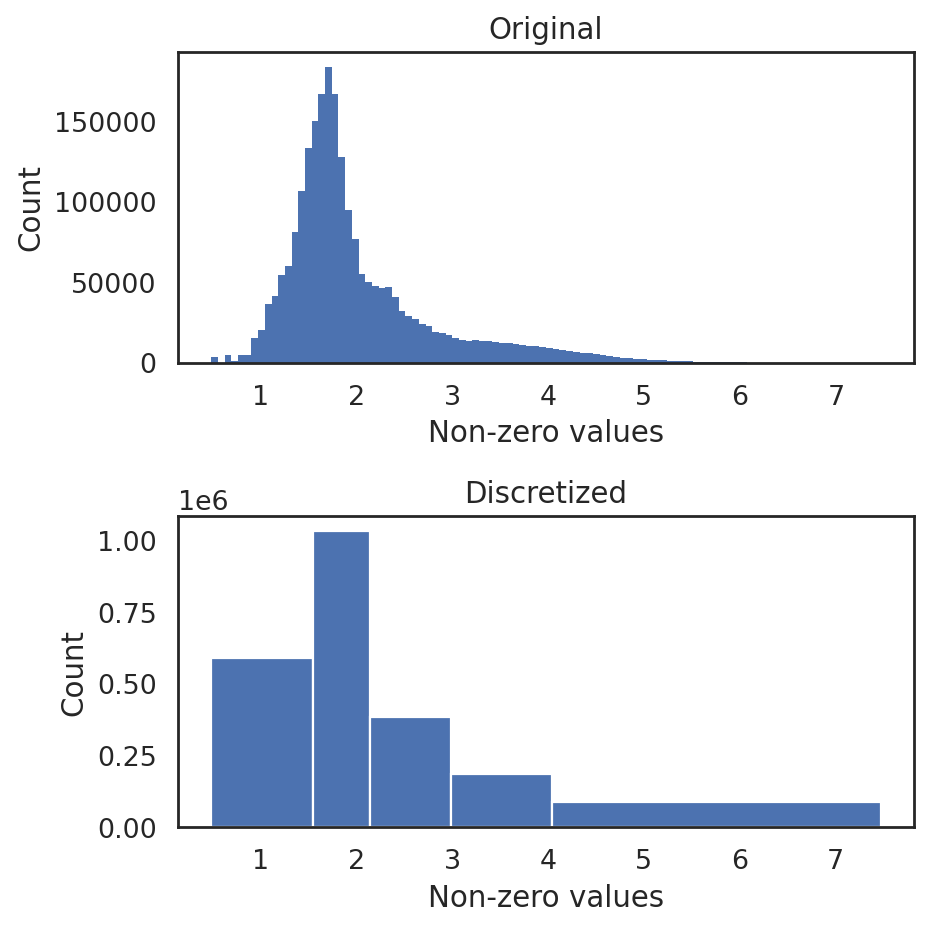

In [11]:
si.tl.discretize(adata_CG,n_bins=5)
si.pl.discretize(adata_CG,kde=False)

#### generate a graph for training

- Observations and variables within each Anndata object are both represented as nodes (entities). 
- Anndata objects specified in `list_CG` (or other list parameters like `list_adata`) will have their nodes automatically matched by comparing their `.obs_names` and `.var_names`.
- The non-zero values in `.layers['simba']` (by default) or `.X` (if `.layers['simba']` does not exist) denote edges between nodes.

For gene expression data, by default, different levels of gene expression are encoded by distinct relations with different weights. 

In [12]:
si.tl.gen_graph(list_CG=[adata_CG],
                layer='simba',
                use_highly_variable=False,
                dirname='graph0')

relation0: source: C, destination: G
#edges: 590134
relation1: source: C, destination: G
#edges: 1034817
relation2: source: C, destination: G
#edges: 384939
relation3: source: C, destination: G
#edges: 185485
relation4: source: C, destination: G
#edges: 87601
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_rnaseq/pbg/graph0" ...
Finished.


## PBG training

Before training, let's take a look at the current parameters:

In [13]:
si.settings.pbg_params

{'entity_path': 'result_simba_rnaseq/pbg/graph0/input/entity',
 'edge_paths': ['result_simba_rnaseq/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.0,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_neg

Typically, the only parameter that may require adjustment is weight decay (`wd`), as indicated by the pbg metric plots presented below. 

In the majority of cases, the automatically determined `wd` value (achieved by enabling `auto_wd=True`) performs adequately.

If no adjustments to the parameters are necessary, training can be performed simply by using the following:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we demonstrate how to modify training-related parameters if necessary. 

E.g. if we desire to change `wd_interval` and `workers`:

In [14]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.015521 
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 12 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.015521
Weight decay being used for training is 0.015521
Converting input data ...
[2023-03-31 15:11:33.795264] Using the 5 relation types given in the config
[2023-03-31 15:11:33.795869] Searching for the entities in the edge files...
[2023-03-31 15:11:36.423366] Entity type C:
[2023-03-31 15:11:36.423785] - Found 2700 entities
[2023-03-31 15:11:36.424074] - Removing the ones with fewer than 1 occurrences...
[2023-03-31 15:11:36.424694] - Left with 2700 entities
[2023-03-31 15:11:36.424994] - Shuffling them...
[2023-03-31 15:11:36.426491] Entity type G:
[2023-03-31 15:11:36.426764] - Found 13714 entities
[2023-03-31 15:11:36.427025] - Removing the ones with fewer than 1 occurrences...
[2023-03-31 15:11:36.429263] - Left with 13714 entities
[2023-03-31 15:11:36.429539] - Shuffling them...
[2023-03-31 15:11:36.436280] Preparing counts and dictionaries for entities and relation types:
[2023-03-31 15:11:36.

Plotting training metrics to monitor overfitting and evaluate the final model. Ideally, after a certain number of epochs, the metric curve should stabilize and remain steady.

By default, training loss (lower is better) along with validation loss (lower is better) and MRR (higher is better) are shown.

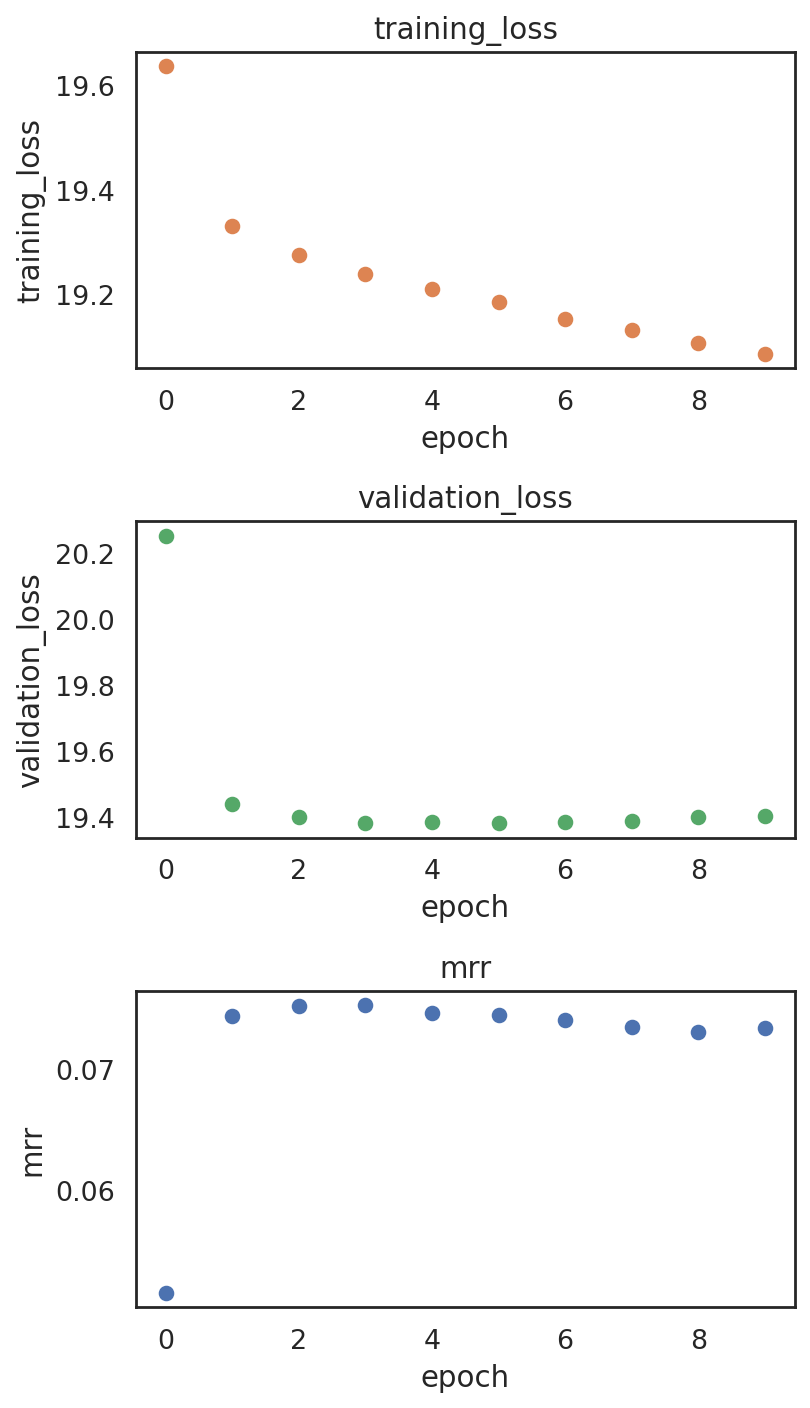

In [15]:
si.pl.pbg_metrics(fig_ncol=1)

If further parameter tuning is required, generating new embeddings using updated parameters while training on the same graph can be achieved by updating the `output` variable, e.g., 
```python
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output="model2")
```
The new result will be stored in `./result_simba_rnaseq/pbg/graph0/model2`.

If needed, the PBG training parameters can be updated using the following function, once the training parameters have been finalized:
```python
si.settings.set_pbg_params(dict_config)
```
If no parameters are specified, `si.settings.set_pbg_params()` will reset PBG training parameters to the step before graph generation. 

To load the trained result, the following steps can be taken:

By default, it uses the current training result stored in `.setting.pbg_params`
```python
# load back 'graph0'
si.load_graph_stats()
# load back 'model' that was trained on 'graph0'
si.load_pbg_config()
```
Users can also specify different paths, e.g.,
```python
# load back 'graph1'
si.load_graph_stats(path='./result_simba_rnaseq/pbg/graph1/')
# load back 'model2' that was trained on 'graph1'
si.load_pbg_config(path='./result_simba_rnaseq/pbg/graph1/model2/')
```

## Post-training analysis

In [20]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'C': AnnData object with n_obs × n_vars = 2700 × 50,
 'G': AnnData object with n_obs × n_vars = 13714 × 50}

In [21]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

#### visualize embeddings of cells

In [22]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

In [23]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e', 
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

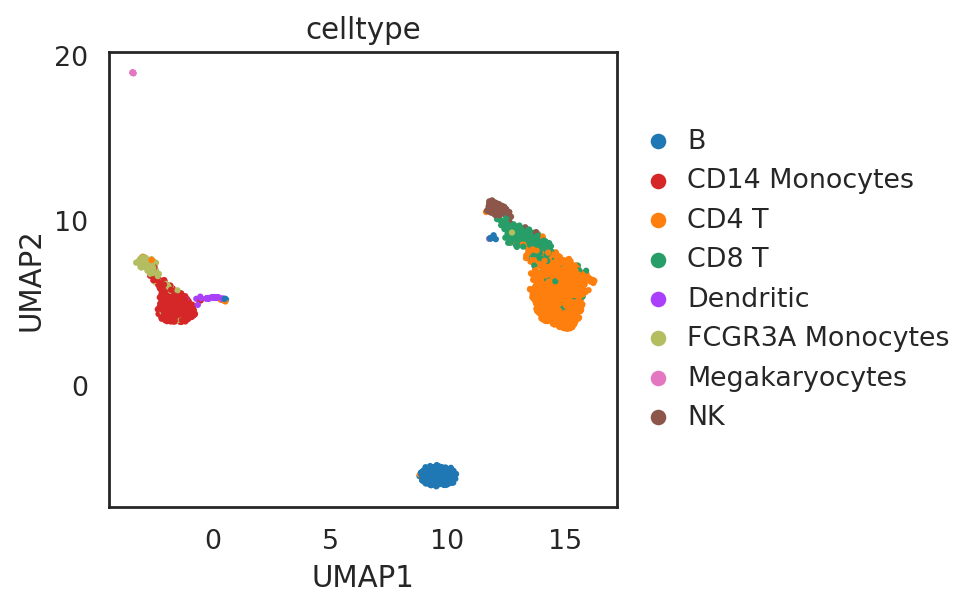

In [24]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

#### visualize embeddings of cells and all genes

In [25]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G])
adata_all.obs.head()

Performing softmax transformation for query data 0;


,celltype,id_dataset
GACTCCTGTTGGTG-1,CD14 Monocytes,ref
TCTAACACCAGTTG-1,NK,ref
GAAACCTGTGCTAG-1,CD4 T,ref
CATTACACCAACTG-1,NK,ref
ACTCAGGATTCGTT-1,CD14 Monocytes,ref


In [26]:
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all.obs.head()

,celltype,id_dataset,entity_anno
GACTCCTGTTGGTG-1,CD14 Monocytes,ref,CD14 Monocytes
TCTAACACCAGTTG-1,NK,ref,NK
GAAACCTGTGCTAG-1,CD4 T,ref,CD4 T
CATTACACCAACTG-1,NK,ref,NK
ACTCAGGATTCGTT-1,CD14 Monocytes,ref,CD14 Monocytes


In [27]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"

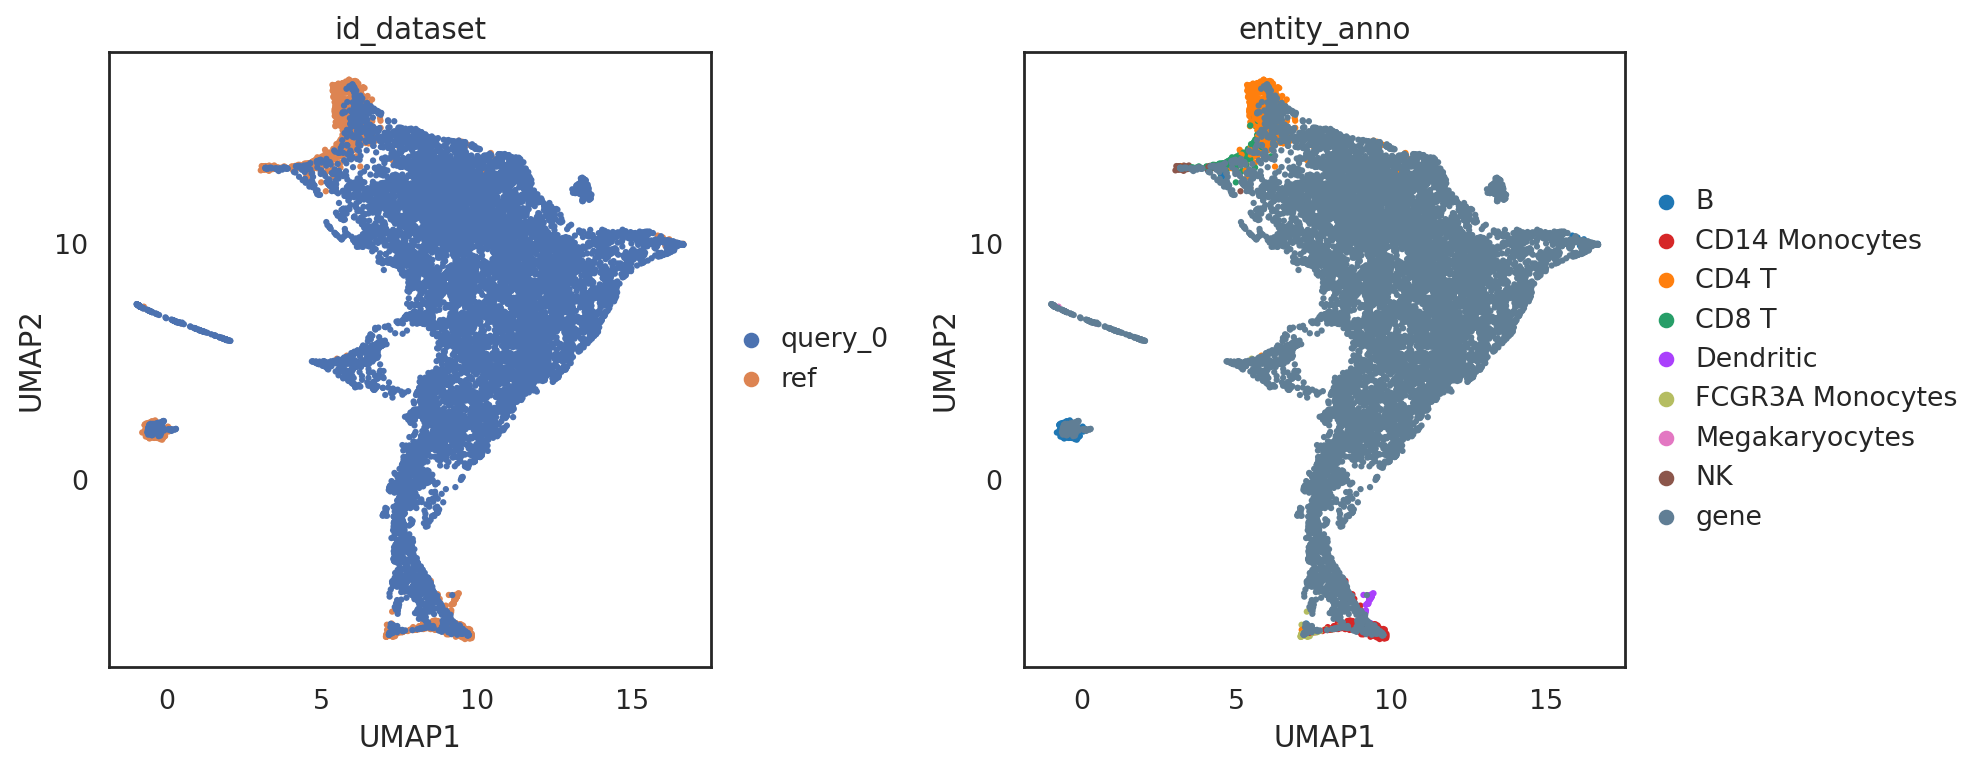

In [28]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)
si.pl.umap(adata_all,color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))

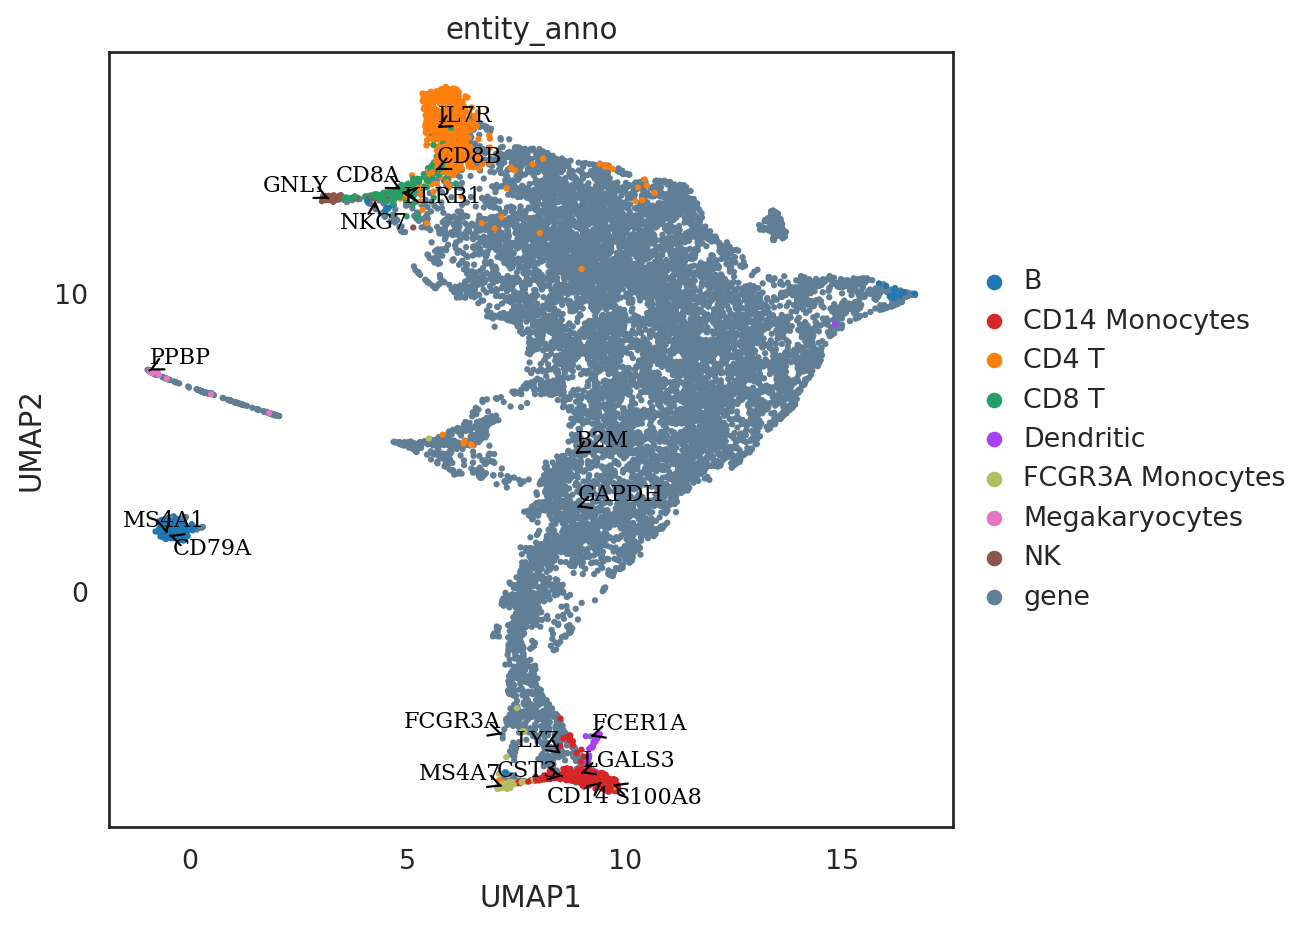

In [29]:
# highlight some marker genes in the co-embedding space
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
si.pl.umap(adata_all[::-1,],color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           texts=marker_genes + ['GAPDH', 'B2M'],
           show_texts=True,
           fig_size=(8,6))

We can also visualize only partial genes (e.g., variable genes) instead of all genes by following the steps below:

```python
# obtain variable genes
si.pp.select_variable_genes(adata_CG, n_top_genes=3000)
var_genes = adata_CG.var_names[adata_CG.var['highly_variable']].tolist()
# obtain SIMBA embeddings of cells and variable genes
adata_all2 = adata_all[list(adata_C.obs_names) + var_genes,].copy()
# visualize them using UMAP
si.tl.umap(adata_all2,n_neighbors=15,n_components=2)
si.pl.umap(adata_all2,color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))
```

#### clustering-free marker discovery

compute SIMBA metrics including max value, Gini index, standard deviation, and entropy, to assess cell-type specificity of genes:

- max: a higher value indicates higher cell-type specificity
- gini: a higher value indicates higher cell-type specificity
- std: a higher value indicates higher cell-type specificity
- entropy: a lower value indicates higher cell-type specificity

In [30]:
adata_cmp = si.tl.compare_entities(adata_ref=adata_C, adata_query=adata_G)
adata_cmp

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype'
    var: 'max', 'std', 'gini', 'entropy'
    layers: 'norm', 'softmax'

In [31]:
# genes can be ranked based on either one or multiple metrics
adata_cmp.var.head()

,max,std,gini,entropy
YIPF5,0.540598,0.229048,0.129493,7.874485
ZDHHC7,0.652473,0.322003,0.184971,7.846139
PSAP,1.165987,0.656630,0.384751,7.636724
ARL4C,1.068365,0.625148,0.327085,7.730876
MYO19,0.325210,0.109136,0.060507,7.894761


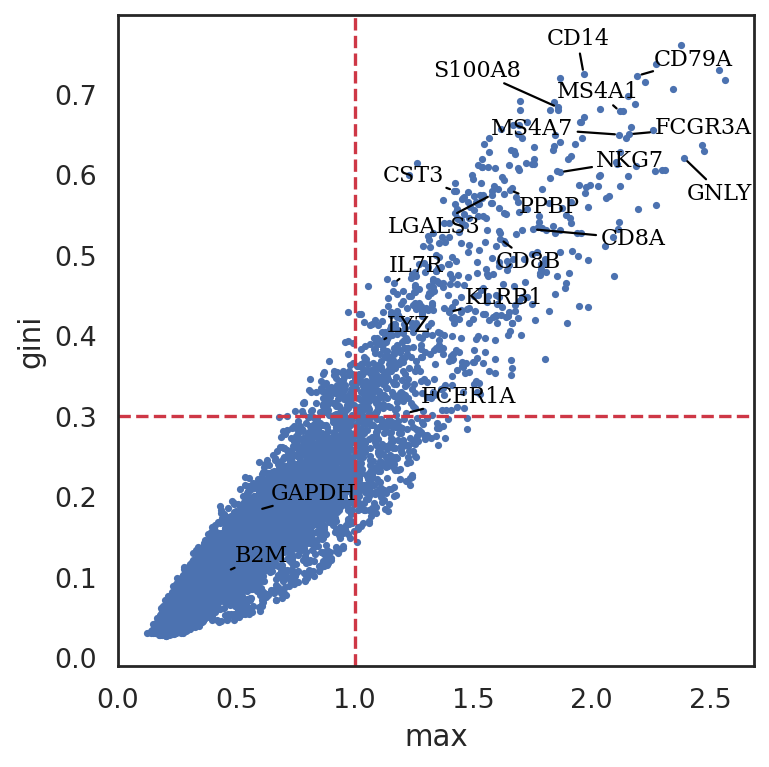

In [32]:
# SIMBA metrics can be visualized using the following function:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_x=1.,
                     cutoff_y=0.3,
                     save_fig=False)

#### SIMBA barcode plot

SIMBA barcode plots visualize feature-cell probability based on edge confidence:
- Imbalance indicates cell-type specificity
- uniform distribution suggests non-specificity.

SIMBA barcode plots

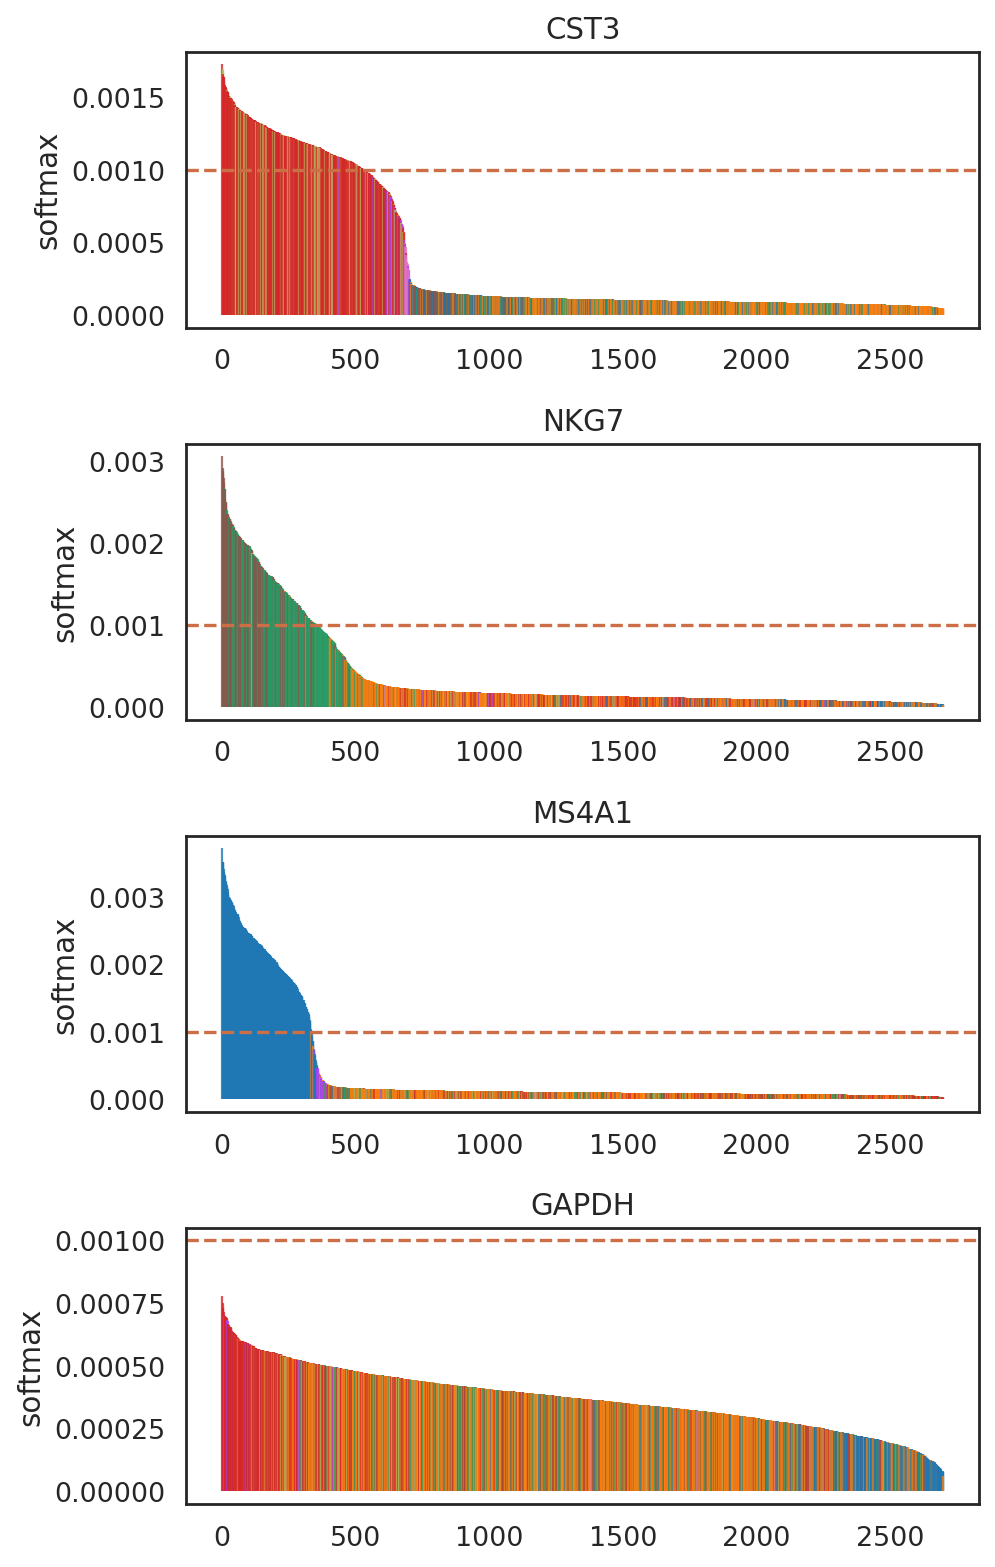

In [33]:
# add annoations of cells
adata_cmp.obs['celltype'] = adata_CG.obs.loc[adata_cmp.obs_names,'celltype']
list_genes = ['CST3', 'NKG7', 'MS4A1', 'GAPDH']
si.pl.entity_barcode(adata_cmp, 
                     layer='softmax',
                     entities=list_genes, 
                     anno_ref='celltype',
                     show_cutoff=True,
                     cutoff=0.001,
                     palette=palette_celltype,
                     fig_size=(6, 2.5),
                     save_fig=False)

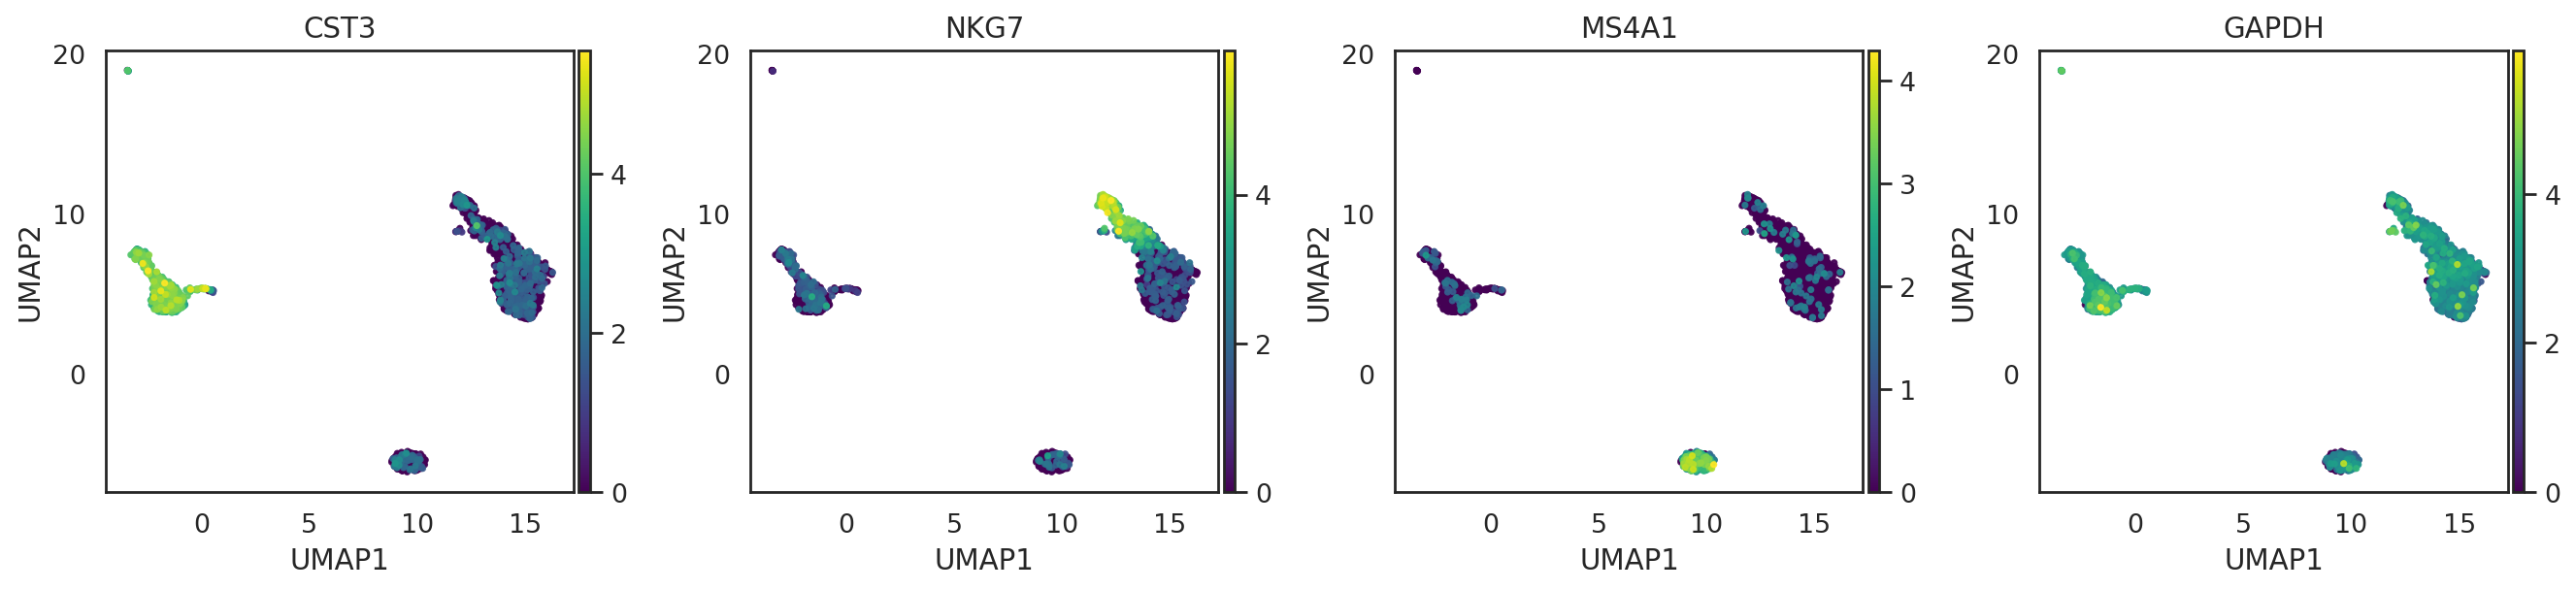

In [35]:
# The same list of genes can also be visualized on UMAP to confirm their cell type specificity
adata_CG.obsm['X_umap'] = adata_C[adata_CG.obs_names,].obsm['X_umap'].copy()
si.pl.umap(adata_CG,
           color=['CST3', 'NKG7', 'MS4A1', 'GAPDH'],
           drawing_order='sorted',
           size=5,
           alpha=0.9,
           fig_ncol=4,
           fig_size=(4,4),
           save_fig=False)

#### Queries of entities in SIMBA space

The SIMBA embedding space, with cells and features, serves as an informative entity database. Queries can be performed on the "SIMBA database" by examining neighboring entities at the individual-cell or individual-feature level.

For example, 
- the query for a cell’s neighboring features can be used to identify marker features (e.g., marker genes) at the individual-cell level.
- the query for features' neighboring cells can be used to annotate cells. 

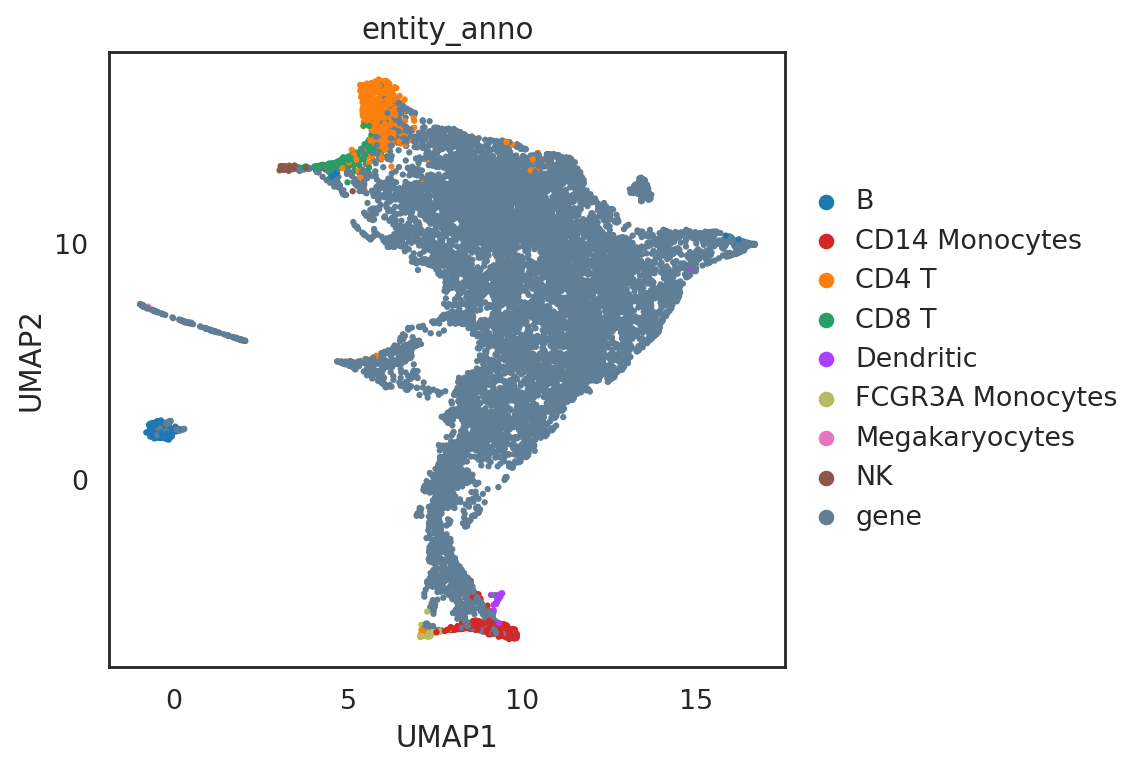

In [36]:
# First, we visualize the SIMBA co-embedding space, which serves as a database of entities including both cells and features (e.g., genes) and also where queries of entities will be performed
si.pl.umap(adata_all,
           color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='random',
           show_texts=False,
           fig_size=(7,5))

In [37]:
# find neighbor genes around the location [6, 16] on UMAP 
query_result = si.tl.query(adata_all,
                           pin=[6,16],
                           obsm='X_umap',
                           use_radius=True,r=2,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

(247, 5)


,celltype,id_dataset,entity_anno,distance,query
AC013264.2,nan,query_0,gene,0.001936,0
PCSK1N,nan,query_0,gene,0.069059,0
TCEA3,nan,query_0,gene,0.082872,0
CD27,nan,query_0,gene,0.091110,0
RP11-18H21.1,nan,query_0,gene,0.105336,0


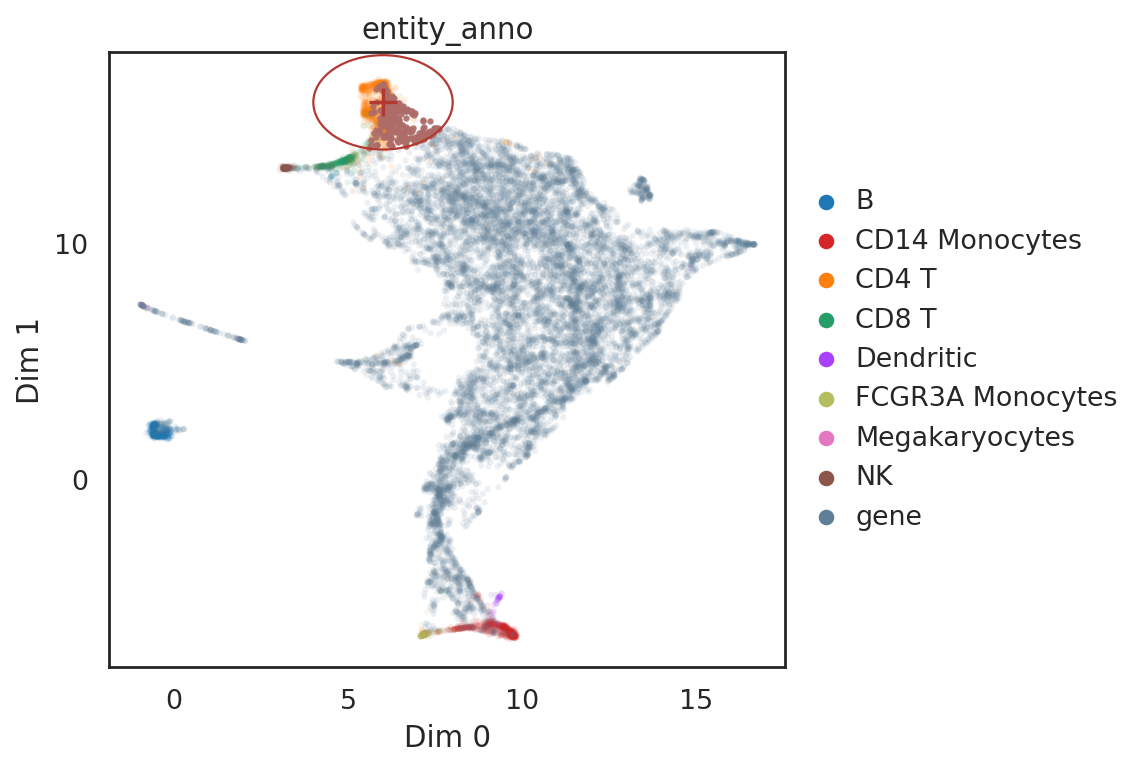

In [38]:
# show locations of pin point and its neighbor genes 
si.pl.query(adata_all,
            show_texts=False, 
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

In [39]:
# find top 50 neighbor genes around cell "ACTCAGGATTCGTT-1" (CD14 Monocytes) in SIMBA space
query_result = si.tl.query(adata_all,
                           entity=['ACTCAGGATTCGTT-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

(50, 5)


,celltype,id_dataset,entity_anno,distance,query
JUND,nan,query_0,gene,1.719076,ACTCAGGATTCGTT-1
CLEC4E,nan,query_0,gene,1.728315,ACTCAGGATTCGTT-1
PTPRE,nan,query_0,gene,1.729887,ACTCAGGATTCGTT-1
QPCT,nan,query_0,gene,1.731332,ACTCAGGATTCGTT-1
NUP214,nan,query_0,gene,1.733139,ACTCAGGATTCGTT-1


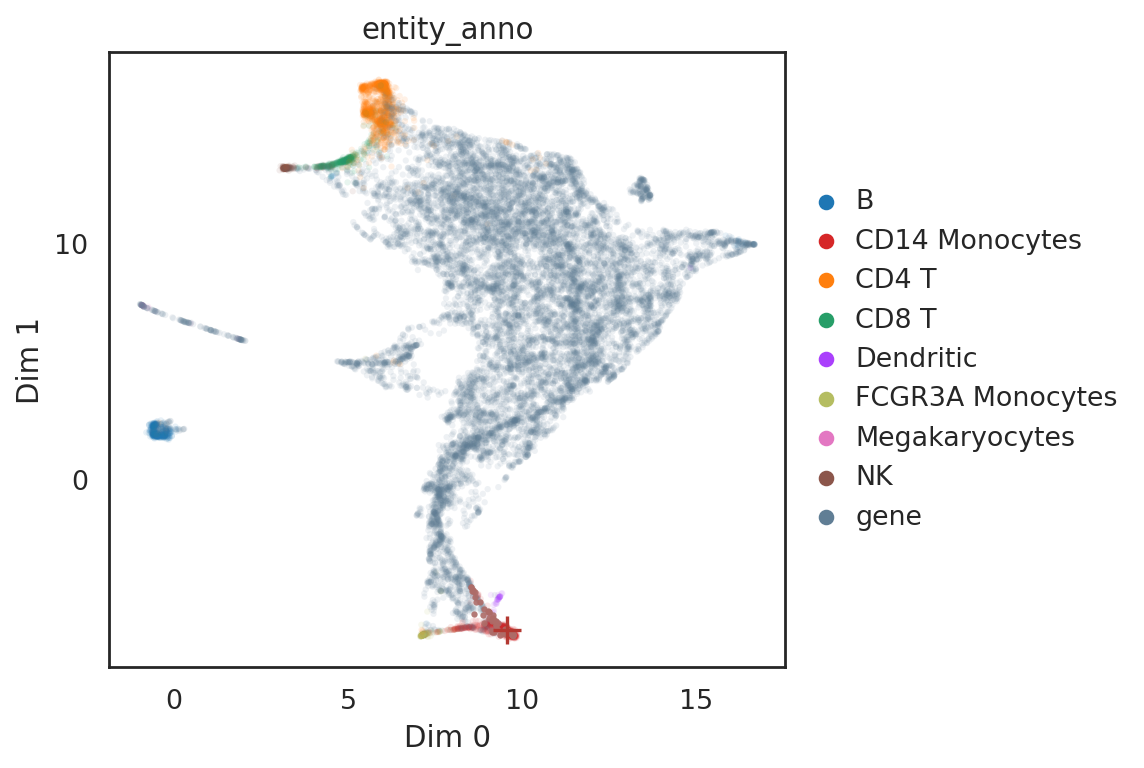

In [40]:
# show locations of entity and its neighbor genes 
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

In [41]:
# find top 50 neighbor genes for multiples cells in SIMBA space
query_result = si.tl.query(adata_all,entity=['GATGCCCTCTCATT-1', 'CTGAAGTGGCTATG-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'],
                           )
print(query_result.shape)
query_result.head()

(100, 5)


,celltype,id_dataset,entity_anno,distance,query
LINC00176,nan,query_0,gene,1.020504,CTGAAGTGGCTATG-1
CCR7,nan,query_0,gene,1.021033,CTGAAGTGGCTATG-1
FHIT,nan,query_0,gene,1.021289,CTGAAGTGGCTATG-1
LDLRAP1,nan,query_0,gene,1.040456,GATGCCCTCTCATT-1
TSHZ2,nan,query_0,gene,1.047881,GATGCCCTCTCATT-1


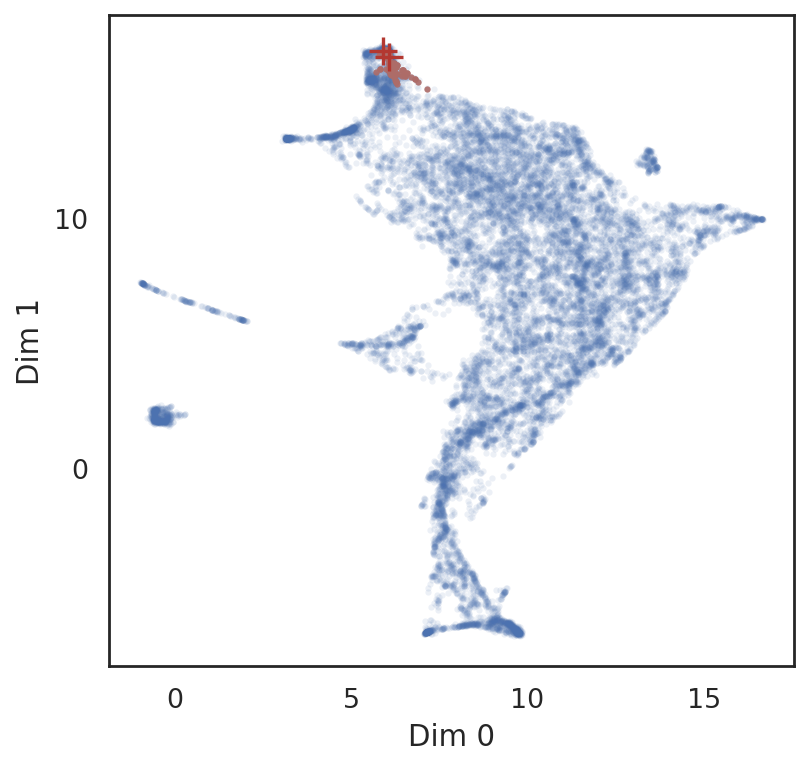

In [42]:
# show locations of entities and their neighbor genes 
si.pl.query(adata_all,
            obsm='X_umap',
            alpha=0.9,
            alpha_bg=0.1,            
            fig_size=(5,5))

In [43]:
# find neighbor entities (both cells and genes) of a given gene on UMAP
query_result = si.tl.query(adata_all,
                           entity=['CD79A'],
                           obsm='X_umap',
                           use_radius=False,
                           k=50
                           )
print(query_result.shape)
query_result.iloc[:10,]

(50, 5)


,celltype,id_dataset,entity_anno,distance,query
CD79A,nan,query_0,gene,0.000000,CD79A
CD19,nan,query_0,gene,0.013946,CD79A
TGGATGTGACCTAG-1,B,ref,B,0.014974,CD79A
ACAAGAGAGTTGAC-1,B,ref,B,0.016267,CD79A
TACATCACGCTAAC-1,B,ref,B,0.022173,CD79A
TTATCCGACTAGTG-1,B,ref,B,0.024351,CD79A
GGAACTTGGGTAGG-1,B,ref,B,0.025603,CD79A
TGCGTAGACGGGAA-1,B,ref,B,0.027751,CD79A
TAACTCACGTACAC-1,B,ref,B,0.028147,CD79A
GATTGGACTTTCGT-1,B,ref,B,0.029059,CD79A


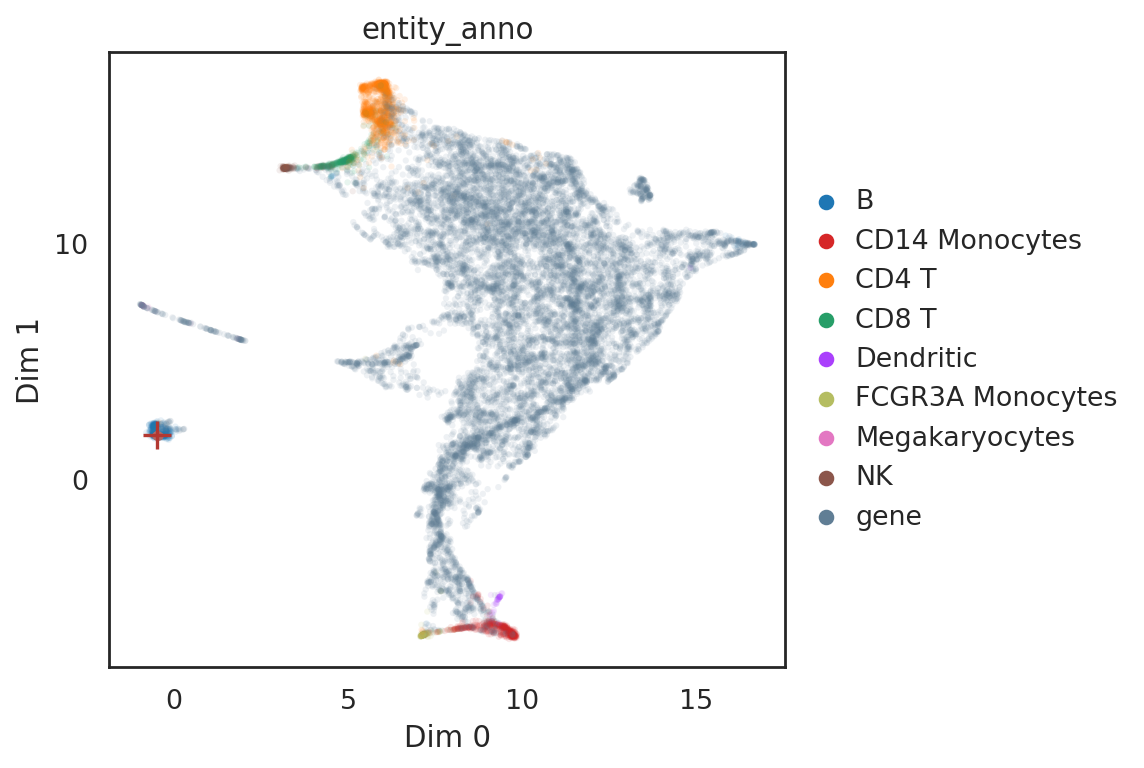

In [44]:
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            show_texts=False,
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

### save results

In [45]:
adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp.write(os.path.join(workdir, 'adata_cmp.h5ad'))

Read back anndata objects
```python
adata_CG = si.read_h5ad(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C = si.read_h5ad(os.path.join(workdir, 'adata_C.h5ad'))
adata_G = si.read_h5ad(os.path.join(workdir, 'adata_G.h5ad'))
adata_all = si.read_h5ad(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp = si.read_h5ad(os.path.join(workdir, 'adata_cmp.h5ad'))
```